# Sentiment Analysis using bag of words
This model focuses completely on the words, or sometimes a string of words, but usually pays no attention to the "context" so-to-speak. The bag of words model usually has a large list, probably better thought of as a sort of "dictionary," which are considered to be words that carry sentiment. These words each have their own "value" when found in text. The values are typically all added up and the result is a sentiment valuation. The equation to add and derive a number can vary, but this model mainly focuses on the words, and makes no attempt to actually understand language fundamentals.



## Importing necessary modules

In [8]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection  import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from sklearn.svm import SVC
from nltk import word_tokenize
stop_words = stopwords.words('english')
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from nltk.stem import PorterStemmer
pd.options.display.max_columns = 30
%matplotlib inline
import xgboost as xgb
from textblob import TextBlob, Word, Blobber


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import os
os.getcwd()
os.chdir('C:/Personal/python work/Sentiment Analysis/project ML/project ML/data_reviews')  

In [2]:
from google.colab import files
files.upload()

Saving y_train.csv to y_train (1).csv
Saving x_train.csv to x_train.csv
Saving x_test.csv to x_test.csv


{'x_test.csv': b'website_name,text\nimdb,"Technically, the film is well made with impressive camera-work, solid acting and effective music from Riz Ortolani -- particularly good is a recurring unaccompanied female vocal that sounds like it\'s coming from a distant hill.  "\nyelp,!....THE OWNERS REALLY REALLY need to quit being soooooo cheap let them wrap my freaking sandwich in two papers not one!\namazon,what a disappointment\nimdb,The movie is terribly boring in places.  \nimdb,"One of the best mexican movies ever!, and one of the less understood, even by mexican themselves, no matter how identified the should have felt with it.  "\nyelp,My boyfriend and I came here for the first time on a recent trip to Vegas and could not have been more pleased with the quality of food and service.\nimdb,"I was very uneasy with how bad this movie was, but not scared at all.  "\namazon,Great Product.\namazon,I highly recommend this device to everyone!\nyelp,Coming here is like experiencing an underw

### Creating pandas dataframe of the dataset. 
#### We're importing x_train which stores the reviews, y_train holds the sentiment values, x_test are the reviews on which we will test our work

In [10]:
x_test = pd.read_csv('x_test.csv')
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
y = y_train['is_positive_sentiment']
y.shape[0]

2400

On displaying the shape we now know that we have 2400 samples. Out of which 1200 are positive and 1200 are negative.

In [0]:
y.value_counts()

1    1200
0    1200
Name: is_positive_sentiment, dtype: int64

### Few pre-processing techniques that could be employed are...
*   Remove all punctuation from words.
*   Remove all words that are not purely comprised of alphabetical characters.
*   Remove all words that are not purely comprised of alphabetical characters.
*   Remove all words that are known stop words.
*   Remove all words that have a length <= 1 character.

### Code for converting all the reviews to lower case


In [0]:
###LOWER CASE############
x_train["text"] = (x_train["text"].apply(lambda x: " ".join(x.lower() for x in x.split())))


In [29]:
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


### Removing all punctuation marks

In [0]:
# Removing punctuation
x_train["text"] = x_train["text"].str.replace('[^\w\s]','')

In [30]:
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


### Lemmatizing all reviews in order to group similar words

In [0]:
####lEMENTIZATIOO#############
x_train["text"]  = (x_train["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))

In [31]:
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


## Stopword elimination
*  Stopwords are words that occur wayy too many times in the given corpus.
*  Stopwords are not helpful or healthy for any alg because we will be wasting time and resource on training them when no o/p can be expected
*  Stopwords lists readily available online from sources such as sklearn etc cannot be used all the time.
*  They cannot be used all the time because, the range of stopwords and their frequency differs from corpus to corpus.
*  Hence it is a healthy to check for the word frequency in the corpus before eliminating all stopwords

### Multiclass logloss
Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    Log loss, aka logistic loss or cross-entropy loss.
    This is the loss function used in (multinomial) logistic regression and 
    extensions of it such as neural networks, defined as the negative log-likelihood of the true labels 
    given a probabilistic classifier’s predictions. The log loss is only defined for two or more labels.
    Accuracy is the count of predictions where your predicted value equals the actual value. 
    Accuracy is not always a good indicator because of its yes or no nature.
    Log Loss takes into account the uncertainty of your prediction based on how much it varies from the actual label. 
    This gives us a more nuanced view into the performance of our model.

In [0]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

## Important Information regarding the Pre-Processing
*  We've only been tokenizing ngrams in the range (1, 3), that means we have separated each and every word without bias

### Splitting out data to train and test sets
*  Here we're dividing the dataset into 4 parts being training set and the validation set.
*  Notice how validation set is different from testing set.
*  We're shuffling the data as we would want the reviews from amazon, yelp and imdb to well mixed

In [0]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x_train['text'], y 
                                                  , stratify=y
                                                  ,random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [13]:
print (xtrain.shape)
print (xvalid.shape)

(2160,)
(240,)


## Intuition on vectorization
*  The simplest scoring method is to mark the presence of words as a boolean value, 0 for absent, 1 for present.

*  Using the arbitrary ordering of words listed above in our vocabulary, we can step through the first document (“It was the best of times“) and convert it into a binary vector.

*  The scoring of the document would look as follows:
consider the example, 
""
*  “it” = 1
*  “was” = 1
*  “the” = 1
*  “best” = 1
*  “of” = 1
*  “times” = 1
*  “worst” = 0
*  “age” = 0
*  “wisdom” = 0
*  “foolishness” = 0
*  As a binary vector, this would look as follows:

*  "it was the worst of times" = [1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
*  "it was the age of wisdom" = [1, 1, 1, 0, 1, 0, 0, 1, 1, 0]
*  "it was the age of foolishness" = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]

## Why vectorize?
Before we can use words in a classifier, we need to convert them into numbers. One way to do that is to simply map words to integers. Another way is to one-hot encode words. Each tweet could then be represented as a vector with a dimension equal to (a limited set of) the words in the corpus. The words occurring in the tweet have a value of 1 in the vector. All other vector values equal zero.

### TF-IDF vector creation and fitting.

In [0]:
######tfidf vector Creation##############
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

*  If careful observation, we have set the ngram_range parameter to be (1, 3). That means the vectorizer is open to "unigram", "bigram" and "trigram" words. 
*  The same range has been specified at the countvectorizer too...

### Count Vector creation and fitting

In [0]:
######Count vector Creation##############
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

# Training Process
## The details of the training are as follows
*  Logistic regression over tfidf
*  Logistic regression over ctv
*  Naive Baye's over tfidv
*  Naive Baye's over ctv
*  Random forest over tfidfv
*  Random forest over ctv
*  Grid search for optimal hyper parameters for Logistic regression, Naive Baye's and Random forest algorithms 
*  Comparative study was made.

## Logistic Regression
*  By default sklearn employs a penalty of "l2" when we call for logistic regression.
*  Logistic regression is the right algorithm to start with classification algorithms. Eventhough, the name ‘Regression’ comes up, it is not a regression model, but a classification model. It uses a logistic function to frame binary output model. The output of the logistic regression will be a probability (0≤x≤1), and can be used to predict the binary 0 or 1 as the output ( if x<0.5, output= 0, else output=1).
*  Cross entropy is used as the loss function in Logistic regression
*  θ parameters explains the direction and intensity of significance
independent variables over the dependent variable.
*  Can be used for multiclass classifications also.
*  Loss function is always convex.

### Fitting a Logistic Regression Model over tfidf vectors

In [16]:
# Fitting a simple Logistic Regression on TFIDF#########
LR_IDF = LogisticRegression(C=1.0,solver='lbfgs')
LR_IDF.fit(xtrain_tfv, ytrain)
predictions = LR_IDF.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
y_pred_Linear = LR_IDF.predict(xvalid_tfv)
##print(y_pred_Linear)
print("Accuracy for Logistic regression on Test TFIDF vector: ",accuracy_score(yvalid, y_pred_Linear))
pred_train=LR_IDF.predict(xtrain_tfv)
print("Accuracy for Logistic regression on Training TFIDF vector: ",accuracy_score(ytrain,pred_train))


logloss: 0.491 
Accuracy for Logistic regression on Test TFIDF vector:  0.7916666666666666
Accuracy for Logistic regression on Training TFIDF vector:  0.9023148148148148


### Fitting a Logistic Regression Model over count vectors


In [17]:
# Fitting a simple Logistic Regression on Counts
LR_Count = LogisticRegression(C=1.0,solver='lbfgs')
LR_Count.fit(xtrain_ctv, ytrain)
predictions = LR_Count.predict_proba(xvalid_ctv)

print ("logloss: %0.2f " % multiclass_logloss(yvalid, predictions))
y_pred_Linear = LR_Count.predict(xvalid_ctv)
###print(y_pred_Linear)
print("Accuracy for logistic regression on Test  Count Vector :",accuracy_score(yvalid, y_pred_Linear))

pred_train=LR_Count.predict(xtrain_ctv)
print("Accuracy for logistic regression on Training  Count Vector : ",accuracy_score(ytrain,pred_train))



logloss: 0.44 
Accuracy for logistic regression on Test  Count Vector : 0.8125
Accuracy for logistic regression on Training  Count Vector :  0.9898148148148148


## Naive Baye's 
*  Naive bayes is a generative model whereas LR is a discriminative model.
*  Naive bayes works well with small datasets, whereas LR+regularization can achieve similar performance.
*  LR performs better than naive bayes upon colinearity, as naive bayes expects *  all features to be independent.


### Fitting a Naive Bayes Model over tfidf vectors


In [18]:
# Fitting a simple Naive Bayes on TFIDF
NB_IDF = MultinomialNB()
NB_IDF.fit(xtrain_tfv, ytrain)
predictions = NB_IDF.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

y_pred_Linear = NB_IDF.predict(xvalid_tfv)
##print(y_pred_Linear)
print("Accuracy for Naive Bayes on Test TFIDF vector: ",accuracy_score(yvalid, y_pred_Linear))
pred_train=NB_IDF.predict(xtrain_tfv)
print("Accuracy for Naive Bayes on Training TFIDF vector: ",accuracy_score(ytrain,pred_train))


logloss: 0.460 
Accuracy for Naive Bayes on Test TFIDF vector:  0.7958333333333333
Accuracy for Naive Bayes on Training TFIDF vector:  0.8953703703703704


### Fitting Naive Baye's Model over count



In [19]:
# Fitting a simple Naive Bayes on Counts
NB_Count = MultinomialNB()
NB_Count.fit(xtrain_ctv, ytrain)
predictions = NB_Count.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
y_pred_Linear = NB_Count.predict(xvalid_ctv)
##print(y_pred_Linear)
print("Accuracy for Naive Bayes on Test  Count Vector :",accuracy_score(yvalid, y_pred_Linear))
pred_train=NB_Count.predict(xtrain_ctv)
print("Accuracy for naive Bayes on Training Count vector: ",accuracy_score(ytrain,pred_train))


logloss: 0.408 
Accuracy for Naive Bayes on Test  Count Vector : 0.8166666666666667
Accuracy for naive Bayes on Training Count vector:  0.9800925925925926


## Random forests 
*  Random forests is a decision tree based algorithm used to solve regression and classification problems. An inverted tree is framed which is branched off from a homogeneous probability distributed root node, to highly heterogeneous leaf nodes, for deriving the output. 
*  Decision tree handles colinearity better than LR.
*  Decision trees cannot derive the significance of features, but LR can.
*  Decision trees are better for categorical values than LR.


### Fitting a Random Forest over tfidf vectors


In [20]:
# # Fitting random forest  on TFIDF
##from sklearn.ensemble import RandomForestClassifier
rf_IDF = RandomForestClassifier(n_estimators = 10, random_state = 42)
rf_IDF.fit(xtrain_tfv, ytrain)
predictions = rf_IDF.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

y_pred =rf_IDF.predict(xvalid_tfv)
##print (y_pred)
print("Accuracy for Random Forest on Test TFIDF vector: ",accuracy_score(yvalid, y_pred_Linear))
pred_train=rf_IDF.predict(xtrain_tfv)
print("Accuracy for Random Forest on Training TFIDF vector: ",accuracy_score(ytrain,pred_train))


logloss: 1.105 
Accuracy for Random Forest on Test TFIDF vector:  0.8166666666666667
Accuracy for Random Forest on Training TFIDF vector:  0.975


### Fitting a Random Forest over count vectors


In [21]:
# # Fitting random forest  on count
rf_Count = RandomForestClassifier(n_estimators = 10, random_state = 42)
rf_Count.fit(xtrain_ctv, ytrain)
predictions = rf_Count.predict_proba(xvalid_ctv)
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
y_pred_Linear = rf_Count.predict(xvalid_ctv)

##print(y_pred_Linear)
print("Accuracy for Random Forest on Test  Count Vector :",accuracy_score(yvalid, y_pred_Linear))

pred_train=rf_Count.predict(xtrain_ctv)
print("Accuracy for Random Forest on Training Count Vector: ",accuracy_score(ytrain,pred_train))


logloss: 1.041 
Accuracy for Random Forest on Test  Count Vector : 0.7166666666666667
Accuracy for Random Forest on Training Count Vector:  0.9828703703703704


### Fitting a XGBoost over tfidf vectors


In [22]:
# Fitting a simple xgboost on tf-idf
XGB_IDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
XGB_IDF.fit(xtrain_tfv, ytrain)
predictions = XGB_IDF.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))


y_pred =XGB_IDF.predict(xvalid_tfv)
##print (y_pred)
print("Accuracy for XgBOOST on Test TFIDF vector: ",accuracy_score(yvalid, y_pred_Linear))
pred_train=XGB_IDF.predict(xtrain_tfv)
print("Accuracy for Logistic regression on Training TFIDF vector: ",accuracy_score(ytrain,pred_train))

logloss: 0.481 
Accuracy for XgBOOST on Test TFIDF vector:  0.7166666666666667
Accuracy for Logistic regression on Training TFIDF vector:  0.8574074074074074


### Fitting a XGBoost over count vectors


In [23]:
# Fitting a simple xgboost on count
XGB_Count = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
XGB_Count.fit(xtrain_ctv, ytrain)
predictions = XGB_Count.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

y_pred_Linear = XGB_Count.predict(xvalid_ctv)
###print(y_pred_Linear)
print("Accuracy for xgboost on Test  Count Vector :",accuracy_score(yvalid, y_pred_Linear))

pred_train=XGB_Count.predict(xtrain_ctv)
print("Accuracy for xgboost on Training count vector: ",accuracy_score(ytrain,pred_train))


logloss: 0.462 
Accuracy for xgboost on Test  Count Vector : 0.775
Accuracy for xgboost on Training count vector:  0.8421296296296297


In [0]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)


## How out of vocab words are handled in Bag of Words
*  As the name suggests, Its a bag of words ie only the words that are there in the bag are considered for prediction. 
*  Unknown words are ignored as they are not in the bag of words
*  Unknown words are handled better in the section below where embeddings are used

## Grid Search
Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

In [0]:

#####Grid Search  Naive Bayes for Count Vector

nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1,10,100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid,
                                 verbose=20, n_jobs=-1, cv=5)

# Fit Grid Search Model
model.fit(xtrain_ctv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Best score: 0.810
Best parameters set:
	nb__alpha: 1


## General intuition on k-fold cross validation

*  The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

*  Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

*  It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

*  The general procedure is as follows:

*  Shuffle the dataset randomly.
*  Split the dataset into k groups
*  For each unique group:
*  Take the group as a hold out or test data set
*  Take the remaining groups as a training data set
*  Fit a model on the training set and evaluate it on the test set
*  Retain the evaluation score and discard the model
*  Summarize the skill of the model using the sample of model evaluation scores


In [0]:
# Fittinng our best params ie nb_alpha=1 in the Naive Baye's algorithm
NB_model_Count_final= MultinomialNB(alpha=1)

### training the Naive Baye's algorithm with the best hyperparameters obtained by GridSearch CV


In [26]:
NB_model_Count_final.fit(xtrain_ctv, ytrain)
predictions = NB_model_Count_final.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
y_pred_Linear = NB_model_Count_final.predict(xvalid_ctv)
# print(y_pred_Linear)
print("Accuracy for Naive Bayes on Test  Count Vector :",accuracy_score(yvalid, y_pred_Linear))
pred_train=NB_model_Count_final.predict(xtrain_ctv)
print("Accuracy for naive Bayes on Training Count vector: ",accuracy_score(ytrain,pred_train))


logloss: 0.408 
Accuracy for Naive Bayes on Test  Count Vector : 0.8166666666666667
Accuracy for naive Bayes on Training Count vector:  0.9800925925925926


In [0]:
classifier = NB_model_Count_final

from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=xtrain_ctv, y=ytrain, cv=5)  

print(all_accuracies)  
print(all_accuracies.mean())
print(all_accuracies.std())

[ 0.80787037  0.81481481  0.80555556  0.83564815  0.78703704]
0.810185185185
0.0156998379239


## Confusion Matrix
### A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

## ROC-AUC Curve
### AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.

In [27]:
confusion_matrix=metrics.confusion_matrix(yvalid, y_pred_Linear)
print(confusion_matrix)
auc_roc=metrics.roc_auc_score(yvalid, y_pred_Linear)
auc_roc
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_pred_Linear)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


[[98 22]
 [22 98]]


0.8166666666666667

Text(0.5, 0, 'False Positive Rate')

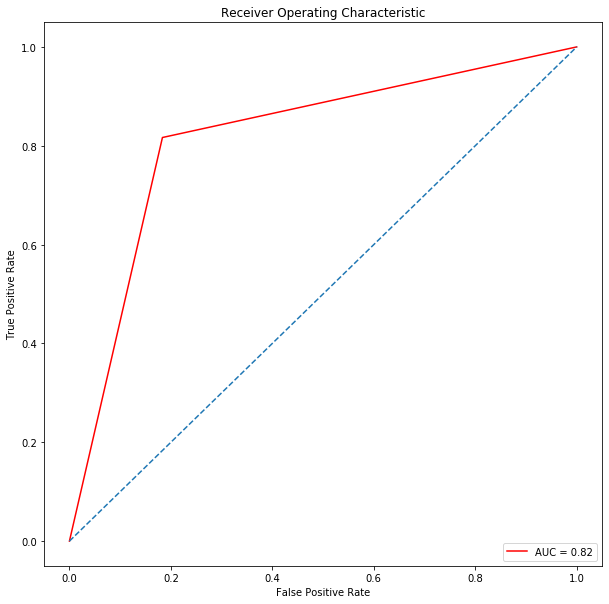

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [0]:
###Grid Search for idf Vector######

nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1,10,100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid,
                                 verbose=20, n_jobs=-1, cv=5)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0179s.) Setting batch_size=22.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


Best score: 0.794
Best parameters set:
	nb__alpha: 1


In [0]:
classifier = MultinomialNB(alpha=1)

from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=xtrain_tfv, y=ytrain, cv=5)  

print(all_accuracies)  
print(all_accuracies.mean())
print(all_accuracies.std())

[ 0.78935185  0.8125      0.77314815  0.80787037  0.78935185]
0.794444444444
0.0142243439775


In [0]:
from sklearn.ensemble import RandomForestClassifier  
classifier = RandomForestClassifier(n_estimators=300, random_state=0)

from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=xtrain_tfv, y=ytrain, cv=5)  

print(all_accuracies)  
print(all_accuracies.mean())
print(all_accuracies.std())  

[ 0.7337963   0.78240741  0.78240741  0.78240741  0.7662037 ]
0.769444444444
0.0188966033629


## Performing Grid Search for random forest classifier

In [0]:
# #Grid Search random forest  on TFIDF
##from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
fit = rf.fit(xtrain_tfv, ytrain)
###predictions = clf.predict_proba(xvalid_tfv)

###print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

In [0]:
grid_param = {  
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [0]:
d_sr = GridSearchCV(estimator=classifier,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [0]:
d_sr.fit(xtrain_tfv, ytrain) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 500, 800, 1000], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Fitting the best result obtained from grid search in the random forest algorithm

In [0]:
best_result = d_sr.best_score_  
print(best_result)  

0.771759259259


In [0]:
rfc1=RandomForestClassifier(random_state=0,bootstrap=True, n_estimators= 500, criterion='gini')

In [0]:
rfc1.fit(xtrain_tfv, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
pred=rfc1.predict(xvalid_tfv)

In [0]:
print("Accuracy for Random Forest on Test data: ",accuracy_score(yvalid,pred))

Accuracy for Random Forest on Test data:  0.791666666667


In [0]:
pred_train=rfc1.predict(xtrain_tfv)
print("Accuracy for Random Forest on Training data: ",accuracy_score(ytrain,pred_train))

Accuracy for Random Forest on Training data:  0.988888888889


In [0]:
from sklearn.ensemble import RandomForestClassifier  
classifier =rfc1
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=xtrain_tfv, y=ytrain, cv=5)  

print(all_accuracies)  
print(all_accuracies.mean())
print(all_accuracies.std())  

[ 0.73842593  0.78240741  0.78009259  0.78703704  0.77083333]
0.771759259259
0.017482599619


## Evaluating all models on the count Vector

In [0]:

#######Models On the Count Vector##########

models = [
    RandomForestClassifier(n_estimators=300, random_state=0),
    MultinomialNB(alpha=1),
    LogisticRegression(),
    xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, xtrain_ctv, ytrain ,scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Box plot
A box plot shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable

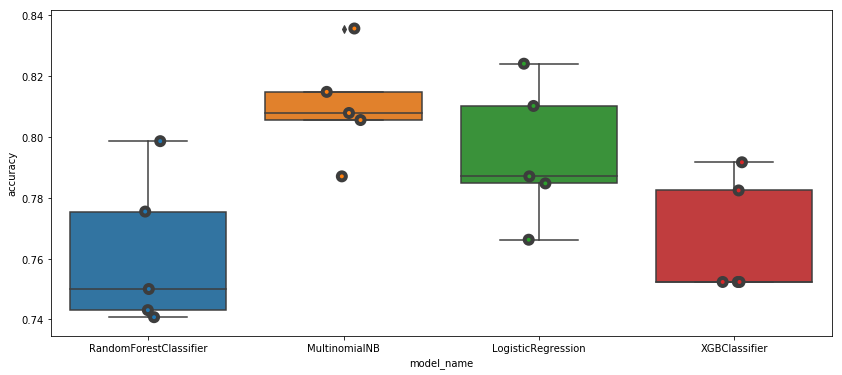

In [0]:
import seaborn as sns
plt.figure(figsize=(14, 6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

# Model Evaluation

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.794444
MultinomialNB             0.810185
RandomForestClassifier    0.761574
XGBClassifier             0.766204
Name: accuracy, dtype: float64

# Concatinating the predicted value and the review in one csv

In [0]:
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
df=pd.concat([x_train,y_train], axis=1)
df['Sentiment'] = np.where(df['is_positive_sentiment']== 1, 'Positive', 'Negative')

In [0]:
df.head()

,website_name,text,is_positive_sentiment,Sentiment
0,amazon,Oh and I forgot to also mention the weird colo...,0,Negative
1,amazon,THAT one didn't work either.,0,Negative
2,amazon,Waste of 13 bucks.,0,Negative
3,amazon,"Product is useless, since it does not have eno...",0,Negative
4,amazon,None of the three sizes they sent with the hea...,0,Negative


In [0]:
from io import StringIO
col = ['Sentiment', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df.columns = ['Sentiment', 'text']
df['Sentiment_id'] = df['Sentiment'].factorize()[0]
Sentiment_id_df = df[['Sentiment', 'Sentiment_id']].drop_duplicates().sort_values('Sentiment_id')
Sentiment_to_id = dict(Sentiment_id_df.values)
id_to_Sentiment = dict(Sentiment_id_df[['Sentiment_id', 'Sentiment']].values)
df.head()

,Sentiment,text,Sentiment_id
0,Negative,Oh and I forgot to also mention the weird colo...,0
1,Negative,THAT one didn't work either.,0
2,Negative,Waste of 13 bucks.,0
3,Negative,"Product is useless, since it does not have eno...",0
4,Negative,None of the three sizes they sent with the hea...,0


In [0]:
xtrain_ctv =  ctv.transform(x_train['text'])

# Heatmaps
### A heatmap is a two-dimensional graphical representation of data where the individual values that are contained in a matrix are represented as colors. 

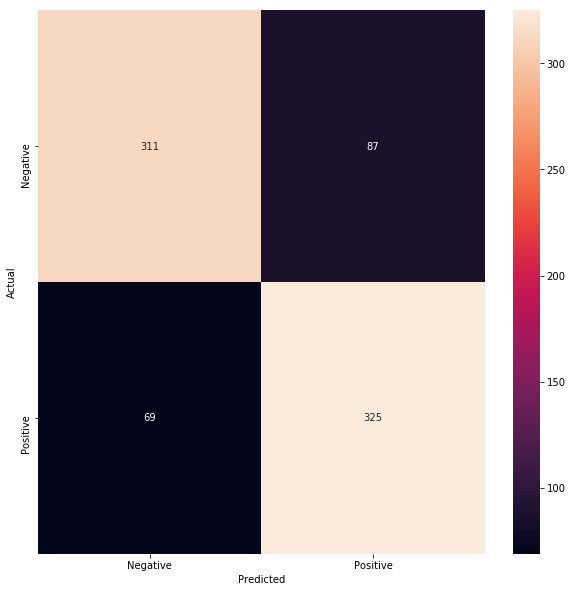

In [0]:
######Model Evaluation
model =MultinomialNB(alpha=1)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split( xtrain_ctv, y_train['is_positive_sentiment'], x_train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=Sentiment_id_df.Sentiment.values, yticklabels=Sentiment_id_df.Sentiment.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Error Analysis
### printing out all the predictions that were proved to be incorrect by the test set and have a conf_mat deviation of more than 10

printing out all the negatives makred positve and all positives marked negative 

In [0]:
from IPython.display import display
for predicted in Sentiment_id_df.Sentiment_id:
  for actual in Sentiment_id_df.Sentiment_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_Sentiment[actual], id_to_Sentiment[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Sentiment', 'text']])
      print('')

'Positive' predicted as 'Negative' : 69 examples.


,Sentiment,text
2097,Positive,"Not to mention the combination of pears, almon..."
657,Positive,"In the span of an hour, I had two people excla..."
452,Positive,Phone now holds charge like it did when it was...
597,Positive,Magical Help.
1252,Positive,"Lovely little thriller from Hitchcock, with lo..."
518,Positive,Someone shouldve invented this sooner.
2083,Positive,We'd definitely go back here again.
666,Positive,I did not have any problem with this item and ...
1442,Positive,"Secondly, Hitchcock pretty much perfected the ..."
1430,Positive,It's as continuously beautiful to look at as a...



'Negative' predicted as 'Positive' : 87 examples.


,Sentiment,text
302,Negative,I ordered this for sony Ericsson W810i but I t...
156,Negative,Steer clear of this product and go with the ge...
1651,Negative,"The descriptions said ""yum yum sauce"" and anot..."
53,Negative,I really wanted the Plantronics 510 to be the ...
893,Negative,If it was to turn my good day feeling into a n...
991,Negative,The only place good for this film is in the ga...
878,Negative,The Foreigner is not worth one second of your ...
1185,Negative,"And, quite honestly, often its not very good."
1639,Negative,It was a pale color instead of nice and char a...
69,Negative,I tried talking real loud but shouting on the ...


In [0]:
####error_rate = (1 - accuracy)
((86+67)/792)*100

19.318181818181817

In [0]:
###LOWER CASE############
x_test["text"] = (x_test["text"].apply(lambda x: " ".join(x.lower() for x in x.split())))
# Removing punctuation
x_test["text"] = x_test["text"].str.replace('[^\w\s]','')
####lEMENTIZATIOO#############
x_test["text"]  = (x_test["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))

# Testing out on the test set....
## Apllying all the pre-processing techniques on the test data..

In [0]:
xtest_ctv =  ctv.transform(x_test["text"])

In [0]:
submission_predictions = NB_model_Count_final.predict_proba(xtest_ctv)[:,1]

In [0]:
print(type(submission_predictions))

<class 'numpy.ndarray'>


## The predictions are as follows

In [0]:
submission_predictions

array([  9.01939110e-01,   2.52761133e-01,   1.31264253e-02,
         4.66082250e-01,   5.28331243e-01,   4.81625590e-02,
         2.94756393e-02,   4.91858368e-02,   4.87083977e-01,
         5.53875263e-01,   6.15716392e-01,   3.54326009e-01,
         2.97638248e-02,   6.83330595e-02,   1.51928573e-01,
         1.06961742e-01,   6.56824745e-03,   1.37984679e-01,
         1.51502725e-02,   4.24294440e-01,   8.91061160e-01,
         7.90546630e-01,   5.00840265e-02,   6.62769491e-01,
         1.47322491e-01,   1.49020222e-01,   6.79380115e-02,
         5.00000000e-01,   3.29697584e-02,   2.72026695e-01,
         4.18219636e-02,   4.48377542e-01,   5.34822748e-01,
         1.00442881e-01,   4.06301304e-01,   2.17093078e-02,
         1.56748217e-01,   3.39178104e-01,   7.85782308e-01,
         6.63682745e-01,   3.94556817e-02,   6.67727802e-03,
         2.16935878e-01,   2.55361316e-02,   9.07179137e-01,
         7.93836981e-02,   6.71277850e-01,   3.09242456e-01,
         2.28141103e-03,

In [0]:
np.savetxt("yproba1_test1.txt", submission_predictions,newline='\r\n',)


In [0]:
np.loadtxt('yproba1_test1.txt')

array([  9.01939110e-01,   2.52761133e-01,   1.31264253e-02,
         4.66082250e-01,   5.28331243e-01,   4.81625590e-02,
         2.94756393e-02,   4.91858368e-02,   4.87083977e-01,
         5.53875263e-01,   6.15716392e-01,   3.54326009e-01,
         2.97638248e-02,   6.83330595e-02,   1.51928573e-01,
         1.06961742e-01,   6.56824745e-03,   1.37984679e-01,
         1.51502725e-02,   4.24294440e-01,   8.91061160e-01,
         7.90546630e-01,   5.00840265e-02,   6.62769491e-01,
         1.47322491e-01,   1.49020222e-01,   6.79380115e-02,
         5.00000000e-01,   3.29697584e-02,   2.72026695e-01,
         4.18219636e-02,   4.48377542e-01,   5.34822748e-01,
         1.00442881e-01,   4.06301304e-01,   2.17093078e-02,
         1.56748217e-01,   3.39178104e-01,   7.85782308e-01,
         6.63682745e-01,   3.94556817e-02,   6.67727802e-03,
         2.16935878e-01,   2.55361316e-02,   9.07179137e-01,
         7.93836981e-02,   6.71277850e-01,   3.09242456e-01,
         2.28141103e-03,

# Summary
*  We have tried out many different algorithms 
**  Logistic regression
**  Naive bayes
**  Random forests 
*  all the three algorithms have been tested on various hyperparameters and cross validation sets
*  In all probablity it is now safe to say that Multinomiaial Naive Bayes algorithm gave us the best output prediction under every circumstance.

# --------------------------------------------------------------------------------------------------------------------------------------------------------------


# **Word** **embeddings**

# Sentiment analysis by creating word vectors
Word Embedding is a representation of text where words that have the same meaning have a similar representation. In other words it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together. In the deep learning frameworks such as TensorFlow, Keras, this part is usually handled by an embedding layer which stores a lookup table to map the words represented by numeric indexes to their dense vector representations.

## Importing necessary modules

In [0]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup 
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection  import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.metrics import accuracy_score
from nltk import word_tokenize
from textblob import TextBlob, Word, Blobber
tokenizer = Tokenizer(num_words=5000)
from sklearn.model_selection import cross_val_score
from sklearn import metrics
%matplotlib inline


In [0]:
###Change Working Directory###

import os
os.getcwd()
os.chdir('C:/Personal/python work/Sentiment Analysis/project ML/project ML/data_reviews') 

### Creating pandas dataframe of the dataset. 
#### We're importing x_train which stores the reviews, y_train holds the sentiment values, x_test are the reviews on which we will test our work

In [0]:
x_test = pd.read_csv('x_test.csv')
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')

In [0]:
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


In [0]:
y_train.head()

,is_positive_sentiment
0,0
1,0
2,0
3,0
4,0


### Few pre-processing techniques that could be employed are...
*   Remove all punctuation from words.
*   Remove all words that are not purely comprised of alphabetical characters.
*   Remove all words that are not purely comprised of alphabetical characters.
*   Remove all words that are known stop words.
*   Remove all words that have a length <= 1 character.

### Code for converting all the reviews to lower case


In [0]:
###LOWER CASE############
x_train["text"] = (x_train["text"].apply(lambda x: " ".join(x.lower() for x in x.split())))

In [0]:
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


### Removing all punctuation marks

In [0]:
# Removing punctuation
x_train["text"] = x_train["text"].str.replace('[^\w\s]','')

In [0]:
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


### Lemmatizing all reviews in order to group similar words

In [0]:
####lEMENTIZATIOO#############
x_train["text"]  = (x_train["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))

In [0]:
x_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


## Stopword elimination
*  Stopwords are words that occur wayy too many times in the given corpus.
*  Stopwords are not helpful or healthy for any alg because we will be wasting time and resource on training them when no o/p can be expected
*  Stopwords lists readily available online from sources such as sklearn etc cannot be used all the time.
*  They cannot be used all the time because, the range of stopwords and their frequency differs from corpus to corpus.
*  Hence it is a healthy to check for the word frequency in the corpus before eliminating all stopwords

## Important Information regarding the Pre-Processing
*  We've only been tokenizing ngrams in the range (1, 3), that means we have separated each and every word without bias

### Splitting out data to train and test sets
*  Here we're dividing the dataset into 4 parts being training set and the validation set.
*  Notice how validation set is different from testing set.
*  We're shuffling the data as we would want the reviews from amazon, yelp and imdb to well mixed

### Splitting out data to train and test sets
On this command we have set the test size as 0.1. That means we're splitting the dataset in to ratio, 10% test and 90% train


In [0]:
X_train_sentence, X_test_sentence, y_train, y_test = train_test_split( x_train['text'],y_train['is_positive_sentiment'],test_size=0.2, random_state = 0)

In [0]:
print(type(X_train_sentence))

<class 'pandas.core.series.Series'>


In [0]:
print(type(y_train))

<class 'pandas.core.series.Series'>


## Intuition on vectorization
*  The simplest scoring method is to mark the presence of words as a boolean value, 0 for absent, 1 for present.

*  Using the arbitrary ordering of words listed above in our vocabulary, we can step through the first document (“It was the best of times“) and convert it into a binary vector.

*  The scoring of the document would look as follows:
consider the example, 
""
*  “it” = 1
*  “was” = 1
*  “the” = 1
*  “best” = 1
*  “of” = 1
*  “times” = 1
*  “worst” = 0
*  “age” = 0
*  “wisdom” = 0
*  “foolishness” = 0
*  As a binary vector, this would look as follows:

*  "it was the worst of times" = [1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
*  "it was the age of wisdom" = [1, 1, 1, 0, 1, 0, 0, 1, 1, 0]
*  "it was the age of foolishness" = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]

## Why vectorize?
Before we can use words in a classifier, we need to convert them into numbers. One way to do that is to simply map words to integers. Another way is to one-hot encode words. Each tweet could then be represented as a vector with a dimension equal to (a limited set of) the words in the corpus. The words occurring in the tweet have a value of 1 in the vector. All other vector values equal zero.

## Word embeddings 
Word vectors were built on this idea. Basically, you get a large corpus, and make a dataset of tuples, where each tuple contains (some word x, a word in the context of x). Then you would use your old friend, a neural network, to learn to predict the context word of x, given the word x.

## Glove
Glove is an unsupervised algorithm to learn and store these contexts between a large number of words. Glove comes as a pre trained model and we will emply it in our work below

In [0]:
########## Using Embedded Word Vector Glove#######
embeddings_index = {}
f = open('C:/Users/Bharti/glove.6B/glove.6B.300d.txt',encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


400000it [00:41, 9727.57it/s] 


Found 400000 word vectors.


### Function to convert sentence to vector
The input sentence in this function is, 
*  Converted to lower case
*  Split into tokens
*  Stripped off stop words
*  All characters other than alphabets have been ommited

In [0]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

### create sentence vectors using the above function for training and validation set

### Word embeddings are computed differently. Each word is positioned into a multi-dimensional space. The number of dimensions in this space is chosen by the data scientist. 

In [0]:
###from keras.preprocessing.text import Tokenizer

xtrain_glove = [sent2vec(x) for x in tqdm(X_train_sentence)]
xvalid_glove = [sent2vec(x) for x in tqdm(X_test_sentence)]

100%|██████████████████████████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 6855.94it/s]


In [0]:
print(type(xtrain_glove))

<class 'list'>


In [0]:
y_train=np.array(y_train)
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

## Fitting of models

# Training Process
## The details of the training are as follows
*  XGBoost was fitted on glove features
*  Logistic regression fitted on glove features
*  Random forests fitted over glove features
*  Grid search for optimal hyper parameters for Logistic regression, XGBoost and Random forest algorithms 
*  Comparative study was made.

## XGBoost
*  XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks.

In [0]:
import xgboost as xgb
XG = xgb.XGBClassifier(nthread=10, silent=False)


### Fitting a simple xgboost on glove features


In [0]:
XG.fit(xtrain_glove, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=10, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [0]:
predictions = XG.predict_proba(xvalid_glove)
y_pred_xg = XG.predict(xvalid_glove)
print(accuracy_score(y_test, y_pred_xg))
y_train_pred_xg = XG.predict(xtrain_glove)
print(accuracy_score(y_train, y_train_pred_xg))

0.785416666667
0.959895833333


In [0]:
classifier = XG

from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=xtrain_glove, y=y_train, cv=5)  

print(all_accuracies)  
print(all_accuracies.mean())
print(all_accuracies.std())

[ 0.75584416  0.82552083  0.78125     0.78645833  0.77023499]
0.783861661891
0.0233225940274


### Fitting a simple Logistic Regression on the Glove features


## Logistic Regression
*  By default sklearn employs a penalty of "l2" when we call for logistic regression.
*  Logistic regression is the right algorithm to start with classification algorithms. Eventhough, the name ‘Regression’ comes up, it is not a regression model, but a classification model. It uses a logistic function to frame binary output model. The output of the logistic regression will be a probability (0≤x≤1), and can be used to predict the binary 0 or 1 as the output ( if x<0.5, output= 0, else output=1).
*  Cross entropy is used as the loss function in Logistic regression
*  θ parameters explains the direction and intensity of significance
independent variables over the dependent variable.
*  Can be used for multiclass classifications also.
*  Loss function is always convex.

In [0]:
LR = LogisticRegression()
LR.fit(xtrain_glove, y_train)


C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
predictions = LR.predict_proba(xvalid_glove)
y_pred_LR = LR.predict(xvalid_glove)
print(accuracy_score(y_test, y_pred_LR))
y_train_pred_LR = LR.predict(xtrain_glove)
print(accuracy_score(y_train, y_train_pred_LR))


0.795833333333
0.836979166667


### Fitting a simple Random Forest on the Glove features


## Random forests 
*  Random forests is a decision tree based algorithm used to solve regression and classification problems. An inverted tree is framed which is branched off from a homogeneous probability distributed root node, to highly heterogeneous leaf nodes, for deriving the output. 
*  Decision tree handles colinearity better than LR.
*  Decision trees cannot derive the significance of features, but LR can.
*  Decision trees are better for categorical values than LR.


In [0]:

rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
rf.fit(xtrain_glove, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
predictions = rf.predict_proba(xvalid_glove)
y_pred_rf = rf.predict(xvalid_glove)
print(accuracy_score(y_test, y_pred_rf))
y_train_pred_rf = rf.predict(xtrain_glove)
print(accuracy_score(y_train, y_train_pred_rf))


0.73125
0.989583333333


## How out of vocab words are handled in word embeddings model
*  adding an unknown word token is how most people solve this problem.
*  deleting the unknown words is a bad idea because it transforms the sentence in a way that is not consistent with how the model was trained.
*  Another option that has recently been developed is to create a word embedding on-the-fly for each word using a convolutional neural network or a separate LSTM that processes the characters of each word one at a time. Using this technique your model will never encounter a word that it can't create an embedding for.

## Grid Search
Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

###  Grid search cross validation for Logistic regression


## General intuition on k-fold cross validation

*  The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

*  Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

*  It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

*  The general procedure is as follows:

*  Shuffle the dataset randomly.
*  Split the dataset into k groups
*  For each unique group:
*  Take the group as a hold out or test data set
*  Take the remaining groups as a training data set
*  Fit a model on the training set and evaluate it on the test set
*  Retain the evaluation score and discard the model
*  Summarize the skill of the model using the sample of model evaluation scores


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(xtrain_glove, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.813020833333


### Applying tbest hyperparameters derived above {'C': 1.0, 'penalty': 'l2'}

# Intuition on L2 regularization
*  In L2 regularization, regularization term is the sum of square of all feature weights as shown above in the equation.
*  L2 regularization forces the weights to be small but does not make them zero and does non sparse solution.
*  L2 is not robust to outliers as square terms blows up the error differences of the outliers and the regularization term tries to fix it by penalizing the weights

In [0]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(xtrain_glove, y_train)


C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
predictions = logreg2.predict_proba(xvalid_glove)
y_pred_LR = logreg2.predict(xvalid_glove)
print(accuracy_score(y_test, y_pred_LR))
y_train_pred_LR = logreg2.predict(xtrain_glove)
print(accuracy_score(y_train, y_train_pred_LR))


0.795833333333
0.836979166667


In [0]:
classifier = logreg2

from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=xtrain_glove, y=y_train, cv=5)  

print(all_accuracies)  
print(all_accuracies.mean())
print(all_accuracies.std())

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

[ 0.78961039  0.83072917  0.80729167  0.80729167  0.81984334]
0.810953246329
0.0138018309731


# Evaluating metrics

## Confusion Matrix
### A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

## ROC-AUC Curve
### AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.

In [0]:
from sklearn.metrics import accuracy_score
confusion_matrix=metrics.confusion_matrix( y_test, y_pred_LR)
confusion_matrix
auc_roc=metrics.roc_auc_score(y_test,  y_pred_LR)
auc_roc

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,  y_pred_LR)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.79581242729908508

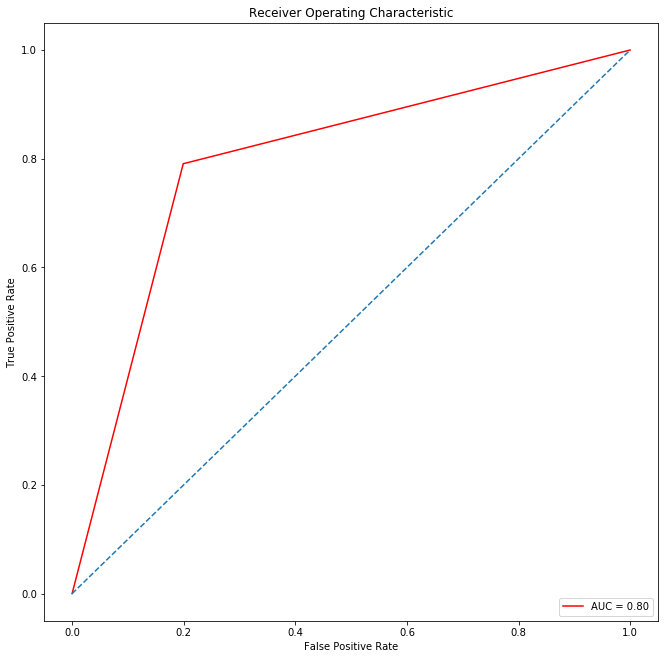

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,11))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Performing Grid Search for random forest classifier

In [0]:
# Grid search cross validation for Random Forest

grid_param = {  
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

grid_sr = GridSearchCV(estimator=rf,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)
grid_sr.fit(xtrain_glove, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 500, 800, 1000], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

### Fitting the best hyperparams obtained from the Grid Search into the random forest algorithm

In [0]:
best_parameters = grid_sr.best_params_  
print(best_parameters) 

best_result = grid_sr.best_score_  
print(best_result)  

{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 800}
0.800520833333


In [0]:
rf2 = RandomForestClassifier(bootstrap=False, n_estimators= 300, criterion='gini')
rf2.fit(xtrain_glove, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
predictions = rf2.predict_proba(xvalid_glove)
y_pred_nv = rf2.predict(xvalid_glove)
print(accuracy_score(y_test, y_pred_nv))
y_train_pred_nv = rf2.predict(xtrain_glove)
print(accuracy_score(y_train, y_train_pred_nv))

0.795833333333
0.9984375


In [0]:
classifier = rf2

from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=xtrain_glove, y=y_train, cv=5)  

print(all_accuracies)  
print(all_accuracies.mean())
print(all_accuracies.std())

[ 0.78181818  0.82291667  0.78125     0.7890625   0.77545692]
0.790100853509
0.0169666781989


## Model evaluation

In [0]:
###### Comparisions Models ##########

models = [
    RandomForestClassifier(bootstrap=False, n_estimators= 300, criterion='gini'),
    xgb.XGBClassifier(nthread=10, silent=False),
    LogisticRegression(C=1,penalty="l2"),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, xtrain_glove, y_train ,scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

## Box plot
A box plot shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable

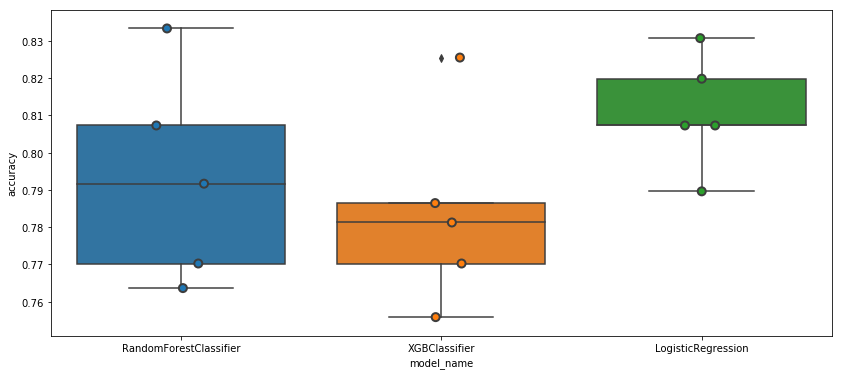

In [0]:
import seaborn as sns
plt.figure(figsize=(14, 6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Comparing the accuracies of various models we so far trained on

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.810953
RandomForestClassifier    0.793233
XGBClassifier             0.783862
Name: accuracy, dtype: float64

In [0]:
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
df=pd.concat([x_train,y_train], axis=1)
df['Sentiment'] = np.where(df['is_positive_sentiment']== 1, 'Positive', 'Negative')

In [0]:
df.head()

,website_name,text,is_positive_sentiment,Sentiment
0,amazon,Oh and I forgot to also mention the weird colo...,0,Negative
1,amazon,THAT one didn't work either.,0,Negative
2,amazon,Waste of 13 bucks.,0,Negative
3,amazon,"Product is useless, since it does not have eno...",0,Negative
4,amazon,None of the three sizes they sent with the hea...,0,Negative


In [0]:
from io import StringIO
col = ['Sentiment', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df.columns = ['Sentiment', 'text']
df['Sentiment_id'] = df['Sentiment'].factorize()[0]
Sentiment_id_df = df[['Sentiment', 'Sentiment_id']].drop_duplicates().sort_values('Sentiment_id')
Sentiment_to_id = dict(Sentiment_id_df.values)
id_to_Sentiment = dict(Sentiment_id_df[['Sentiment_id', 'Sentiment']].values)
df.head()

,Sentiment,text,Sentiment_id
0,Negative,Oh and I forgot to also mention the weird colo...,0
1,Negative,THAT one didn't work either.,0
2,Negative,Waste of 13 bucks.,0
3,Negative,"Product is useless, since it does not have eno...",0
4,Negative,None of the three sizes they sent with the hea...,0


In [0]:
x_train = pd.read_csv('x_train.csv')
xtrain_glove_whole = [sent2vec(x) for x in tqdm(x_train['text'])]
xtrain_glove_whole = np.array(xtrain_glove_whole)


100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:00<00:00, 4393.18it/s]


In [0]:
y_train = pd.read_csv('y_train.csv')
y = y_train['is_positive_sentiment']



# Heatmaps
### A heatmap is a two-dimensional graphical representation of data where the individual values that are contained in a matrix are represented as colors. 

C:\Users\Bharti\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


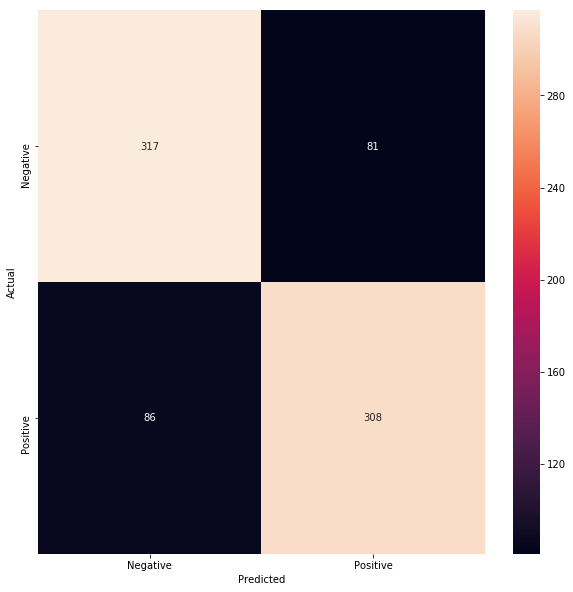

In [0]:
######Model Evaluation
model =LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split( xtrain_glove_whole, y, x_train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=Sentiment_id_df.Sentiment.values, yticklabels=Sentiment_id_df.Sentiment.values)

####,xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Error Analysis
We now are going to print out the values that were predicted incorrectly and conf_mat showed more that 10 point deviation. 

### we will print out all the negatives makred positve and all positives marked negative below

In [0]:
from IPython.display import display
for predicted in Sentiment_id_df.Sentiment_id:
  for actual in Sentiment_id_df.Sentiment_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_Sentiment[actual], id_to_Sentiment[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Sentiment', 'text']])
      print('')

'Positive' predicted as 'Negative' : 86 examples.


,Sentiment,text
657,Positive,"In the span of an hour, I had two people excla..."
453,Positive,"Overall, I would recommend this phone over the..."
757,Positive,"Otherwise, easy to install and use, clear sound."
1252,Positive,"Lovely little thriller from Hitchcock, with lo..."
518,Positive,Someone shouldve invented this sooner.
2083,Positive,We'd definitely go back here again.
461,Positive,"It seems completely secure, both holding on to..."
1205,Positive,"Okay, I like to consider myself a fair critic,..."
775,Positive,I would recommend it.
666,Positive,I did not have any problem with this item and ...



'Negative' predicted as 'Positive' : 81 examples.


,Sentiment,text
398,Negative,The plug did not work very well.
156,Negative,Steer clear of this product and go with the ge...
1938,Negative,Main thing I didn't enjoy is that the crowd is...
1651,Negative,"The descriptions said ""yum yum sauce"" and anot..."
953,Negative,I know that Jim O'Connor was very energetic an...
53,Negative,I really wanted the Plantronics 510 to be the ...
1631,Negative,"Unfortunately, it only set us up for disapppoi..."
1174,Negative,"Unless you're just out to visually ""collect"" a..."
1185,Negative,"And, quite honestly, often its not very good."
1639,Negative,It was a pale color instead of nice and char a...


In [0]:
error=((81+86)/(317+308+81+86))*100
error

21.085858585858585

### Testing trained model on the testing set defined at the begining. 

Creating word vectors of the test set

In [0]:
x_test_glove = [sent2vec(x) for x in tqdm(x_test['text'])]

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 4495.78it/s]


Using model to predict the probability of sentiment

In [0]:
submission_predictions = logreg2.predict_proba(x_test_glove)[:,1]

In [0]:
np.savetxt("yproba1_test2.txt", submission_predictions,newline='\r\n')

In [0]:
np.loadtxt('yproba1_test2.txt')

array([ 0.52881107,  0.54081668,  0.4638553 ,  0.72467578,  0.04275819,
        0.56686163,  0.11354054,  0.38609225,  0.47275304,  0.58486227,
        0.2349594 ,  0.41815094,  0.18633195,  0.60178052,  0.22483625,
        0.70985399,  0.04815831,  0.10314947,  0.04265733,  0.40463557,
        0.23157581,  0.86341809,  0.24865914,  0.42905021,  0.40110432,
        0.6122092 ,  0.16113687,  0.03836311,  0.40991639,  0.41287436,
        0.36910941,  0.41825852,  0.08748183,  0.500365  ,  0.18435184,
        0.59120308,  0.37864136,  0.73520586,  0.80270582,  0.5375466 ,
        0.06913529,  0.24247678,  0.59843234,  0.09405597,  0.24082562,
        0.25962808,  0.26434089,  0.20434426,  0.16817869,  0.40991639,
        0.11125801,  0.01743481,  0.60750347,  0.76178598,  0.21922775,
        0.32486693,  0.2571091 ,  0.06114849,  0.47556055,  0.31917451,
        0.28481965,  0.39422126,  0.11125801,  0.10083284,  0.55940921,
        0.22798478,  0.26006717,  0.85460782,  0.23212741,  0.36

# Summary


In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.810953
RandomForestClassifier    0.793233
XGBClassifier             0.783862
Name: accuracy, dtype: float64

### Based on the mean accuracy given by the three algorithms used, 
*  It is safe to conclude that Logistic regression is the best classification algorithm
*  With the emplyment of L2 regularization set by the hyperparameter tuning the cost function that was employed was relatively efficient
